# Teach a smartcab to drive
## Project 4 for the Udacity Machine Learning Nanodegree
 In this project, we will use Q-learning to train a smartcab to follow traffic rules and reach it's destination in a timely manner.
 
 All code was developed in the accompanying Jupiter notebook, and exported directly to the agent.py, located in the smartcab directory. The project report may be viewed with or without code included inline, by choosing the appropriate pdf, or directly from the ipynb file as a notebook.
 

## Setup

You need Python 2.7 and pygame for this project: https://www.pygame.org/wiki/GettingStarted
For help with installation, it is best to reach out to the pygame community [help page, Google group, reddit].



In [1]:
# Import what we need, and setup the basic function to run from later.

import math
import string
import sys
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
try: # attempt to determine if we are running within a notebook or on the console.
    cfg = get_ipython().config 
    if cfg['IPKernelApp']['parent_appname'] == 'ipython-notebook':
        print "in notebook"
        from IPython.display import display # Allows the use of display() for DataFrames
        %matplotlib inline    
    else:
        print "in notebook"
        from IPython.display import display # Allows the use of display() for DataFrames
        %matplotlib inline  
    console=False # either condition above means that we are in a Notebook
except NameError:
    print "in console"
    console=True
    
sys.path.append("./smartcab/")
from environment import Agent, Environment
from planner import RoutePlanner
from simulator import Simulator

print "Environment ready"

in notebook
Environment ready


In [2]:
# Several of the provided modules output unuseful information during each run. 
#  Here we provide a way to supress that output as needed. 
class outputRedirect():
    def __init__(self):
        self.stout_orig=sys.stdout  # save the current state
    
    def reset(self): #restore to the original state when initiated
        sys.stdout = self.stout_orig
        print "stdout restored!"
        
    def suppress_output(self): # a well formed name for the default of the redirect_output
        self.redirect_output()
        
    def redirect_output(self,f= open(os.devnull, 'w')): # redirect to f, if provided, otherwise to null
        try:
            print "redirecting stdout...."
            sys.stdout = f
        except:
            return "couldn't open destination..."
            self.reset = f
            
redirector=outputRedirect()

print "Redirector ready"

Redirector ready


In [24]:
def run(agentType,trials=10, gui=False, deadline=True, delay=0):
    """Run the agent for a finite number of trials."""
    
    # Set up environment and agent
    
    if gui ==False:
        redirector=outputRedirect()
        redirector.suppress_output()
        delay=0
    
    e = Environment()  # create environment (also adds some dummy traffic)
    a = e.create_agent(agentType)  # create agent
    e.set_primary_agent(a, enforce_deadline=deadline)  # specify agent to track
    # NOTE: You can set enforce_deadline=False while debugging to allow longer trials

    # Now simulate it
    sim = Simulator(e, update_delay=delay, display=gui)  # create simulator (uses pygame when display=True, if available)
    # NOTE: To speed up simulation, reduce update_delay and/or set display=False

    sim.run(n_trials=trials)  # run for a specified number of trials
    # NOTE: To quit midway, press Esc or close pygame window, or hit Ctrl+C on the command-line
    
    if gui ==False:
        redirector.reset()    
        
    print "Successful runs = {}".format(a.goal)
    print "----------------------------------------------------------"
    features= [] # the state at each turn in the run
    deadlines = [] # the deadline at each turn in the run
    for i in range(len(a.features)):
        features.append(pd.DataFrame(a.features[i]).T)
        deadlines.append(a.deadline[i])
        
    rewards=[] # the total reward for each run
    for i in range(len(a.total_reward)):
        rewards.append(a.total_reward[i])


    try:
        print "Qtable: ",len(a.Qtable)
        print "state=light, oncoming, right, left, next_waypoint  / actions= {}\n".format(a.availableAction)
        for r in a.Qtable:
            print "state={}, {}, {}, {}, {} / action={}".format(r[0],r[1],r[2],r[3],r[4], a.Qtable[r])
    except:
        print "no Qtable"

    return features,deadlines,rewards
    

print "run ready"

run ready


In [31]:
# display the feedback from the prior runs graphically
def statsFromRun(feat,DL,RW):
    left=pd.Series()
    light=pd.Series()
    next_waypoint=pd.Series()
    oncoming=pd.Series()
    right=pd.Series()
    for f in feat:
        left= left.add(pd.value_counts(f.left.ravel()), fill_value=0)
        light= light.add(pd.value_counts(f.light.ravel()), fill_value=0)
        next_waypoint= next_waypoint.add(pd.value_counts(f.next_waypoint.ravel()), fill_value=0)
        oncoming= oncoming.add(pd.value_counts(f.oncoming.ravel()), fill_value=0)
        right= right.add(pd.value_counts(f.right.ravel()), fill_value=0)

    fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(14,6))
    fig.suptitle( "Runs:{}".format(len(feat)))

    left.plot(kind='bar', title="Left",ax=axes[0,0])
    light.plot(kind='bar', title="light",ax=axes[0,1])
    next_waypoint.plot(kind='bar', title="next_waypoint",ax=axes[0,2])
    oncoming.plot(kind='bar', title="oncoming",ax=axes[1,0])
    right.plot(kind='bar', title="right",ax=axes[1,2])
    axes[1,1].plot(DL,label="Deadlines")
    axes[1,1].plot(RW,label="Rewards")
    avgDist=3
    axes[1,1].plot(     #add a line to the graph representing the avg of all point within avgDist of the current run. 
        [(np.mean(DL[i-avgDist:i+avgDist])+np.mean(RW[i-avgDist:i+avgDist]))/2 for i in range(len(DL))],
        label="Avg {:2.2f}".format( # use the last half avg in the label
            (np.mean(DL[len(DL)/2:len(DL)])+np.mean(RW[len(DL)/2:len(DL)]))/2)) 
    #axes[1,1].xlabel('Run')
    axes[1,1].legend(loc=2)
    #axes[1,1].title("Deadline and Rewards per Run")
    
    plt.show()
    plt.close()
    
    
def scorePerRun(DL,RW):
    plt.figure(figsize=(14,6))
    plt.plot(DL,label="Deadlines")
    plt.plot(RW,label="Rewards")
    avgDist=3
    plt.plot(     #add a line to the graph representing the avg of all point within avgDist of the current run. 
        [(np.mean(DL[i-avgDist:i+avgDist])+np.mean(RW[i-avgDist:i+avgDist]))/2 for i in range(len(DL))],
        label="Avg: {:2.2f}".format( # use the last half avg in the label
            (np.mean(DL[len(DL)/2:len(DL)])+np.mean(RW[len(RW)/2:len(RW)]))/2)) 
    
    plt.plot(     #add a line to the graph representing the distance of the RW from the DL 
        [(np.mean(RW[i-avgDist:i+avgDist])-np.mean(DL[i-avgDist:i+avgDist]))/2 for i in range(len(DL))],
        label="Avg RW - DL: {:2.2f}".format( # use the last half avg in the label
            (np.mean(RW[len(RW)/2:len(RW)])-np.mean(DL[len(DL)/2:len(DL)]))/2)) 
    avgDist=6
    
    plt.plot(     #add a line to the graph representing the avg of DL within avgDist of the current run. 
        [np.mean(DL[i-avgDist:i+avgDist]) for i in range(len(DL))],
        label="DL Avg: {:2.2f}".format( # use the last half avg in the label
            np.mean(DL[len(DL)/2:len(DL)]))) 
    plt.plot(     #add a line to the graph representing the avg of RW within avgDist of the current run. 
        [np.mean(RW[i-avgDist:i+avgDist]) for i in range(len(RW))],
        label="RW Avg: {:2.2f}".format( # use the last half avg in the label
            np.mean(RW[len(RW)/2:len(RW)]))) 
    
    
    plt.xlabel('Run')
    plt.legend()
    plt.title("Deadline and Rewards per Run")
    plt.show()
    plt.close()

print "Graph display ready"    

Graph display ready


## Implement a basic driving agent

Implement the basic driving agent, which processes the following inputs at each time step:

Next waypoint location, relative to its current location and heading,
Intersection state (traffic light and presence of cars), and,
Current deadline value (time steps remaining),
And produces some random move/action (None, 'forward', 'left', 'right'). Don’t try to implement the correct strategy! That’s exactly what your agent is supposed to learn.

Run this agent within the simulation environment with enforce_deadline set to False (see run function in agent.py), and observe how it performs. In this mode, the agent is given unlimited time to reach the destination. The current state, action taken by your agent and reward/penalty earned are shown in the simulator.

In your report, mention what you see in the agent’s behavior. Does it eventually make it to the target location?


In [32]:
class RandomAgent(Agent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(RandomAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = ['forward', 'left', 'right',None]   
        self.goal=0
        self.steps=0
        self.features=[]
        self.deadline=[]
        self.total_reward=[0]

    def reset(self, destination=None):
        self.planner.route_to(destination)
        # TODO: Prepare for a new trip; reset any variables here, if required
        #print"RESET, Final state:\n", self.state
        try:
            if self.deadline[len(self.features)-1] >0: #deadline less than zero
                self.goal+=1 #FIXME - order
                print "PASS! {} steps to goal,Goal reached {} times out of {}!".format(
                                                        self.deadline[len(self.features)-1],self.goal,len(self.features))
            else:
                print "FAIL! {} steps to goal,Goal reached {} times out of {}!".format(
                                                        self.deadline[len(self.features)-1],self.goal,len(self.features))
                pass
        except:
            print "Trial 0 - Goal reached {} times out of {}!".format(self.goal,len(self.features))
            pass
        print "----------------------------------------------------------"
        self.features.append({})
        self.deadline.append(None)
        self.total_reward.append(0)
        self.steps=0

    def update(self, t):
        # Gather inputs
        self.steps+=1
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        #self.deadline[len(self.features)] = self.env.get_deadline(self)
        self.state=inputs
        self.features[len(self.features)-1][self.steps]=inputs
        self.deadline[len(self.deadline)-1] = self.env.get_deadline(self)

        # TODO: Select action according to your policy
        action = self.availableAction[random.randint(0,3)]    
        
        # Execute action and get reward
        reward = self.env.act(self, action)
        self.lastReward=reward
        # TODO: Learn policy based on state, action, reward
        self.total_reward[len(self.total_reward)-1] =self.total_reward[len(self.total_reward)-1]+reward
        #print "LearningAgent.update():deadline{}, inputs{}, action = {}, reward = {}, next_waypoint = {}".format(
        #                                            deadline, inputs, action, reward,self.next_waypoint, )  # [debug]
print "RandomAgent ready"

RandomAgent ready


In [33]:
if console == False:
    features,deadlines, rewards=run(agentType=RandomAgent,trials=2, deadline=False) #Example of a random run, with no deadline
    print "RandomAgent, no deadlines, Done"

redirecting stdout....
stdout restored!
Successful runs = 0
----------------------------------------------------------
Qtable:  no Qtable
RandomAgent, no deadlines, Done


In [34]:
if console == False:
    features,deadlines, rewards=run(agentType=RandomAgent,trials=2, deadline=True) #Example of a random run
    print "RandomAgent, with deadlines, Done"

redirecting stdout....
stdout restored!
Successful runs = 0
----------------------------------------------------------
Qtable:  no Qtable
RandomAgent, with deadlines, Done


### Random Agent - Discussion:

When we run an agent with a random action policy, we see that it will move about the board with no pattern, and will eventually reach the destination, in most cases. If we allow the use of deadlines, we see that the agent rarely reaches the destination in time, although it may still occur.

---------------------------------------------------------------


## Identify and update state

Identify a set of states that you think are appropriate for modeling the driving agent. The main source of state variables are current inputs, but not all of them may be worth representing. Also, you can choose to explicitly define states, or use some combination (vector) of inputs as an implicit state.

At each time step, process the inputs and update the current state. Run it again (and as often as you need) to observe how the reported state changes through the run.

In [35]:
class StateAgent(RandomAgent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(StateAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = ['forward', 'left', 'right',None]   
        self.next_waypoint   = None
        self.goal=0
        self.steps=0
        self.features=[]
        self.total_reward=[0]

        
    def update(self, t):
        # Gather inputs
        self.steps+=1
        
        self.lastWaypoint = self.next_waypoint
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        
        deadline = self.env.get_deadline(self)
        
        # TODO: Update state
        
        inputs['next_waypoint']=self.next_waypoint
        self.state= inputs    
        self.deadline[len(self.deadline)-1] = self.env.get_deadline(self)
        self.features[len(self.features)-1][self.steps]=inputs
        # TODO: Select action according to your policy

        action = self.availableAction[random.randint(0,3)]    
    
        # Execute action and get reward
        reward = self.env.act(self, action)
        # TODO: Learn policy based on state, action, reward

        self.total_reward[len(self.total_reward)-1] =self.total_reward[len(self.total_reward)-1]+reward

        #print "LearningAgent.update(): self.state{}, action = {}, reward = {}, next_waypoint = {}".format(
        #                                        self.state, action, reward,self.next_waypoint, )  # [debug]
print "StateAgent Ready"

StateAgent Ready


redirecting stdout....
stdout restored!
Successful runs = 24
----------------------------------------------------------
Qtable:  no Qtable


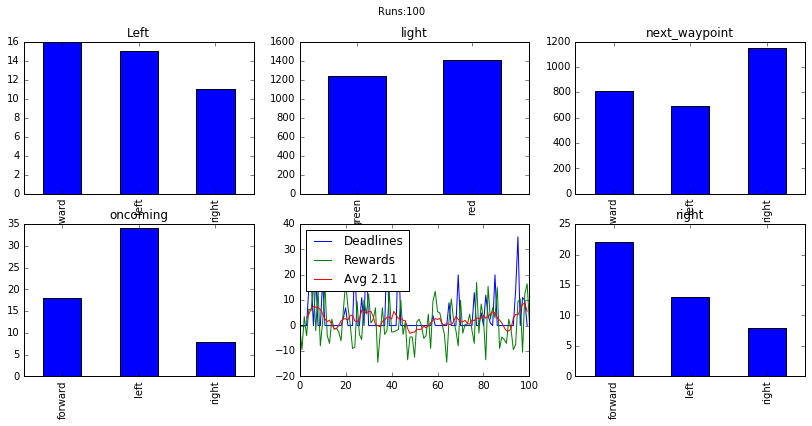

StateAgent done


In [36]:
if console == False:
    # run the trials for the state
    stateFeatures,StateDeadlines,StateRewards=run(agentType=StateAgent,trials=100)    
    statsFromRun(stateFeatures,StateDeadlines,StateRewards)
    #scorePerRun(StateDeadlines,StateRewards)
    print "StateAgent done"


### Identify and update state - Discussion.
When we sense our environment, we perceive 5 variables, with several possible states These include: left, light, next_waypoint, oncoming, and right. We can see right away that light and next_waypoint contains new information at every poll, while the others usually have no value. 

It's not readily apparent that the direction of travel information of the other cars (described by left/right/oncoming) is relevant to our agent. A case could be made to remove the direction information, and only retain information about another car being present at the light. This would have the benefit of reducing the number of possible states, increasing the learning speed of the agent. This may be a valuable approach in resource constrained environments. 

The downside is that the agent may pick an action that causes a longer trip. Early in the learning phase, it could also pick an action incorrectly. For instance, by proceeding through a light when the opposite car is turning left. In this case, it may have previously seen a positive reward for moving through the light, because the opposite car was not turning. This time through, it will receive a negative reward, and in the future when a car is at the oncoming light, it will always wait till the intersection is clear.

In the interest of correct action, we will choose to use the state as returned from the sensor, with the addition of the next_waypoint.

While I have tracked the deadline, it is not apparent that it will provide useful information to the agent. It is useful to  note that the agent does not see any change in the deadline value yet. We may expect this to adapt as we implement learning.

---------------------------------------------------------------

## Implement Q-Learning

Implement the Q-Learning algorithm by initializing and updating a table/mapping of Q-values at each time step. Now, instead of randomly selecting an action, pick the best action available from the current state based on Q-values, and return that.

Each action generates a corresponding numeric reward or penalty (which may be zero). Your agent should take this into account when updating Q-values. Run it again, and observe the behavior.

What changes do you notice in the agent’s behavior?



In [37]:
class BasicLearningAgent(RandomAgent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(BasicLearningAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = [None,'forward', 'left', 'right']   
        self.next_waypoint   = None
        self.goal=0
        self.steps=0
        self.features=[]
        self.Qtable={}
        self.epsilon=0.0
        self.gamma=0.0
        self.total_reward=[0]

    def get_state(self):
        inputs = self.env.sense(self)
        inputs['next_waypoint']=self.planner.next_waypoint()
        return (inputs['light'], inputs['oncoming'], inputs['right'], inputs['left'],inputs['next_waypoint'])
    
    def set_action(self):
        action = self.availableAction[random.randint(0,3)]    #take a random action
   
        # 1-epsilon % of time, refer to the q-table for an action. take the max value from the available actions
        if self.epsilon < random.random() and  self.Qtable.has_key(self.state): 
            action=self.availableAction[self.Qtable[self.state].index(max(self.Qtable[self.state]))]
        return action    
        
    def update_q_table(self,action,reward):
        if not self.Qtable.has_key(self.state):
            self.Qtable[self.state]=[0,0,0,0]
       
        new_state=self.get_state()
        if not self.Qtable.has_key(new_state):
            self.Qtable[new_state]=[0,0,0,0]
            
        self.Qtable[self.state][self.availableAction.index(action)]=reward+self.gamma*max(self.Qtable[new_state])
                                                                                          
        
    def update(self, t):
                                                                                          
        # Gather inputs
        self.steps+=1
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        
        # TODO: Update state
        self.state = self.get_state()
        
        #store details of this run
        self.deadline[len(self.deadline)-1] = self.env.get_deadline(self)
        self.features[len(self.features)-1][self.steps]=self.env.sense(self)
        self.features[len(self.features)-1][self.steps]['next_waypoint']=self.planner.next_waypoint()
        
        # TODO: Select action according to your policy
        action = self.set_action()
        # Execute action and get reward
        reward = self.env.act(self, action)

        # TODO: Learn policy based on state, action, reward
        self.update_q_table(action,reward)
        
        #store details about our rewards
        self.total_reward[len(self.total_reward)-1] =self.total_reward[len(self.total_reward)-1]+reward

        
print "BasicLearningAgent Ready"

BasicLearningAgent Ready


redirecting stdout....
stdout restored!
Successful runs = 27
----------------------------------------------------------
Qtable:  43
state=light, oncoming, right, left, next_waypoint  / actions= forward, left, right,None 

state=green, None, None, right, forward / action=[0, 0, -0.5, 0]
state=green, right, None, None, right / action=[0.0, 0, 0, 0]
state=green, None, right, None, right / action=[0, 0, 0, 2.0]
state=red, forward, None, None, forward / action=[0.0, 0, 0, 0]
state=green, None, None, None, left / action=[0, 0, 2.0, 0]
state=red, left, None, None, forward / action=[0.0, 0, -1.0, 0]
state=green, None, None, left, forward / action=[0, 2.0, 0, 0]
state=red, None, left, None, forward / action=[0.0, 0, 0, -0.5]
state=red, left, None, None, right / action=[0.0, -1.0, 0, 0]
state=green, None, right, None, forward / action=[0, 2.0, 0, 0]
state=red, None, None, right, right / action=[0.0, -1.0, 0, 0]
state=red, None, None, None, left / action=[0.0, 0, -1.0, 0]
state=red, None, forward

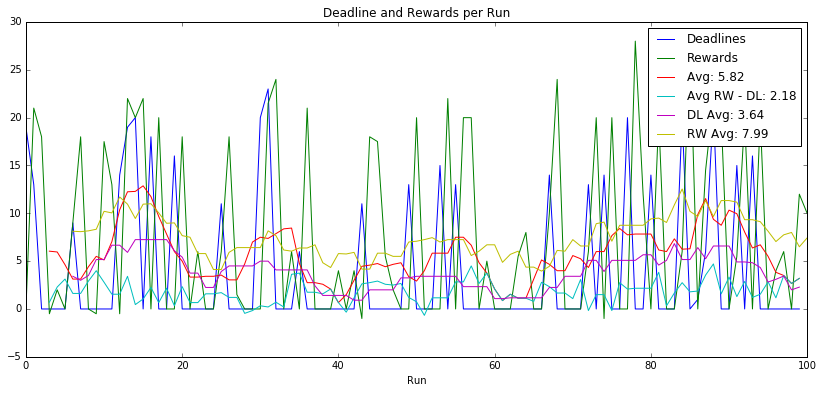

Basic Q Learning Agent done


In [38]:
if console == False:
    # run the trials for the Basic Q learning agent
    basicLearnFeatures,BLdeadlines,BLrewards=run(agentType=BasicLearningAgent,trials=100, deadline=True) 
    #statsFromRun(basicLearnFeatures,BLdeadlines,BLrewards)
    scorePerRun(BLdeadlines,BLrewards)
    print "Basic Q Learning Agent done"

redirecting stdout....
stdout restored!
Successful runs = 97
----------------------------------------------------------
Qtable:  39
state=light, oncoming, right, left, next_waypoint  / actions= forward, left, right,None 

state=green, None, forward, None, forward / action=[2.0, 0, 0, 0]
state=green, None, right, None, forward / action=[12.0, 0, -0.5, 0]
state=red, left, None, None, left / action=[-1.0, 0, 0, 0]
state=red, forward, None, None, forward / action=[-1.0, -1.0, -0.5, 0.0]
state=green, None, None, None, left / action=[-0.5, 12.0, 0, 0]
state=red, left, None, None, forward / action=[-1.0, -1.0, -0.5, 0.0]
state=green, None, None, left, forward / action=[2.0, 0, 0, 0]
state=red, None, left, None, forward / action=[-1.0, 0, 0, 0.0]
state=red, left, None, None, right / action=[-1.0, -1.0, 2.0, 0]
state=red, None, None, right, left / action=[0, 0, 0, 0]
state=green, right, None, None, forward / action=[2.0, 0, 0, 0]
state=green, None, right, None, None / action=[0, 0, 0, 0]
state=

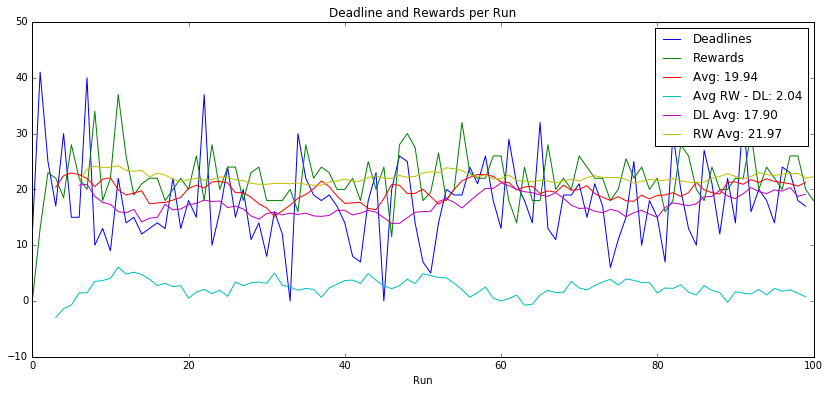

Basic Q Learning Agent2 done


In [39]:
class BasicLearningAgent2(BasicLearningAgent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(BasicLearningAgent2, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = ['forward', 'left', 'right',None]   
        self.next_waypoint   = None
        self.goal=0
        self.steps=0
        self.features=[]
        self.Qtable={}
        self.epsilon=0.0
        self.gamma=0.0
        self.total_reward=[0]
        
if console == False:
    # run the trials for the Basic Q learning agent
    basicLearn2Features,BL2deadlines,BL2rewards=run(agentType=BasicLearningAgent2,trials=100, deadline=True) 
    #statsFromRun(basicLearn2Features,BL2deadlines,BL2rewards)
    scorePerRun(BL2deadlines,BL2rewards)
    print "Basic Q Learning Agent2 done"

### Implement Q-Learning - Discussion
With a basic Qlearning algorithm, we note that the agent quickly learns a set of rules that allow the agent to move toward the objective. Generally  speaking the agent, is moving to the destination, but does not always make optimal choices.  We see the agent begin to obey some traffic rules and make moves toward its destination. We can see that now the reward in each run is generally positive.

We don't see a large continued increase in the agent speed toward the destination after the initial runs. We still see strange behavior such as repeated right turns back to the original destination, or staying in a no action state for extended periods, without much change in pattern through the run. With Epsilon set to 0, we don't see the agent select new behaviors, and with Gamma at 0 we don't consider our future state.

One interesting note is the difference made by re-ordering the available action list. Placing the 'None' value at the end plays to the bias of the 'max' function, in which if all values are the same, will select the first match. Since we initialize the list to zero, if 'None' is first in the list, the agent tends to take no action, and never reaches the goal. By reordering the list, we bias the agent toward action, allowing the agent to perform significantly better. 

---------------------------------------------------------------

## Enhance the driving agent

Apply the reinforcement learning techniques you have learnt, and tweak the parameters (e.g. learning rate, discount factor, action selection method, etc.), to improve the performance of your agent. Your goal is to get it to a point so that within 100 trials, the agent is able to learn a feasible policy - i.e. reach the destination within the allotted time, with net reward remaining positive.

Report what changes you made to your basic implementation of Q-Learning to achieve the final version of the agent. How well does it perform?

Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties?

In [40]:
class LearningAgent(BasicLearningAgent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(LearningAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = [ None,'forward', 'left', 'right']   
        self.next_waypoint = None
        self.goal=0
        self.steps=0
        self.features=[]
        self.Qtable={}
        self.epsilon=0.95
        self.gamma=0.05
        self.total_reward=[0] 
    
    def set_action(self):
        #initially we want to prefer a random action, but later we would like to trust our experience.
        exploration_rate=32 #rate at which we approach final epsilon-> higher is slower
        self.epsilon = self.epsilon-(self.epsilon-.05)/exploration_rate
        
        action = self.availableAction[random.randint(0,3)]    #take a random action
        # 1-epsilon % of time, refer to the q-table for an action. take the max value from the available actions
        if self.epsilon < random.random() and  self.Qtable.has_key(self.state): 
            action=self.availableAction[self.Qtable[self.state].index(max(self.Qtable[self.state]))]
        return action  
        
    def update_q_table(self,action,reward):
        # if we haven't seen this state yet, initialize it
        if not self.Qtable.has_key(self.state):
            self.Qtable[self.state]=[random.uniform(-1,1),random.uniform(-1,1),random.uniform(-1,1),random.uniform(-1,1)]
        #we took an action, so can now observe our new state.
        new_state=self.get_state()
        if not self.Qtable.has_key(new_state):
            self.Qtable[new_state]=[random.uniform(-1,1),random.uniform(-1,1),random.uniform(-1,1),random.uniform(-1,1)]
        
        #initially we should have a very low gamma, as we can't trust our knowledge.
        # as time goes by we should give more weight to our knowledge and grow gamma.
        rate=16 #-> higher is slower
        self.gamma=self.gamma+(.35-self.gamma)/rate
                
        #Set the new value in the Q table based on the Q-learning method
        self.Qtable[self.state][self.availableAction.index(action)]=reward+self.gamma*max(self.Qtable[new_state])
                                                                                          
    def update(self, t):
                                                                                          
        # Gather inputs
        self.steps+=1
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        
        # TODO: Update state
        self.state = self.get_state()
        
        #store details of this run
        self.deadline[len(self.deadline)-1] = self.env.get_deadline(self)
        self.features[len(self.features)-1][self.steps]=self.env.sense(self)
        self.features[len(self.features)-1][self.steps]['next_waypoint']=self.planner.next_waypoint()
        
        # TODO: Select action according to your policy
        action = self.set_action()
        # Execute action and get reward
        reward = self.env.act(self, action)

        # TODO: Learn policy based on state, action, reward
        self.update_q_table(action,reward)
        
        #store details about our rewards
        self.total_reward[len(self.total_reward)-1] =self.total_reward[len(self.total_reward)-1]+reward

        
print "LearningAgent Ready"

LearningAgent Ready


## Enhance the driving agent - Discussion
We immediately  see the agent begin learning when we begin using epsilon to explore new states. The addition of gamma provides many of the same benefits, and we see that the agent learns to reach the destination as quickly as the first or second run. Following this, the agent will quickly begin to reach it's destination well before the deadline, with a positive score, the majority of times. This is despite biasing the action list to 'None', as in the previous example. Even at the end of the run, we do still see odd behaviors, as the agent tries new methods according to epsilon, or encounters new states.

In addition to tuning the final epsilon and gamma, I have added the ability for each to adjust the amount they affect the outcome over time. Initially we want to prefer a random action, as our table is now initialized with random values, and we want to explore the available states, and record their effects. The opposite is true for gamma. In it's case, we would like to highly discount any initial knowledge initially, and over time grow to trust what we know. My implementation allows us to control the rate of change over time of each. I have selected starting/ending values and rates based on experimentation, but we would likely be able to optimize these numbers further by implementing a grid search type algorithm to test the values over multiple runs, etc. 

We could also implement methods to adjust these rates based on factors other than time, for example based on the difference between the current and new values in the Q table for the state, but my initial attempts haven't been successful in finding a model that learns as fast as the current implementations.

I have also changed the Q-table initialization to use random values from -1 to 1. This is intended to assist early phase learning of each state taking random actions, increasing state exploration.

It should be noted that the change that most affects success from the initial algorithm was to re-order the selection of available actions, such that forward is preferred over inaction. This led to an agent that was successful  in reaching it's goal at least as often as any other enhancement, usually reaching the goal more than 96% of the time. This may be a quirk of the environment, and not something that is true generally, especially  when the learning is moved to environment's that may have a larger state space, or with a more complex reward system. 

We do see that the final model has a higher average Reward-Deadline per run, which implies that the final model used is taking a higher scoring path and faster path to it's destination each run.


---------------------------------------------------------------

running....
redirecting stdout....
stdout restored!
Successful runs = 94
----------------------------------------------------------
Qtable:  47
state=light, oncoming, right, left, next_waypoint  / actions= forward, left, right,None 

state=green, None, None, forward, forward / action=[-0.9813300013807704, 2.0, 0.6163135628476204, 0.06987253067828192]
state=green, None, right, None, forward / action=[0.31324168627092797, 2.0, 0.22332263675574549, 0.6368014345931898]
state=red, left, None, None, left / action=[0.10319091558899207, -0.8001189280633412, -0.8374571951863562, -0.9064114135527055]
state=green, None, forward, None, left / action=[0.34369652101141424, 0.4790862630991982, 0.13064885922962266, 0.19999999999999907]
state=red, forward, None, None, forward / action=[-0.7793120268900651, 0.3555878352563968, -0.6923372532648939, 0.5625472701957193]
state=green, None, None, None, left / action=[0.21930591069231883, -0.28847208990866907, 2.0, 0.9638311808365885]
state=red, left, None, N

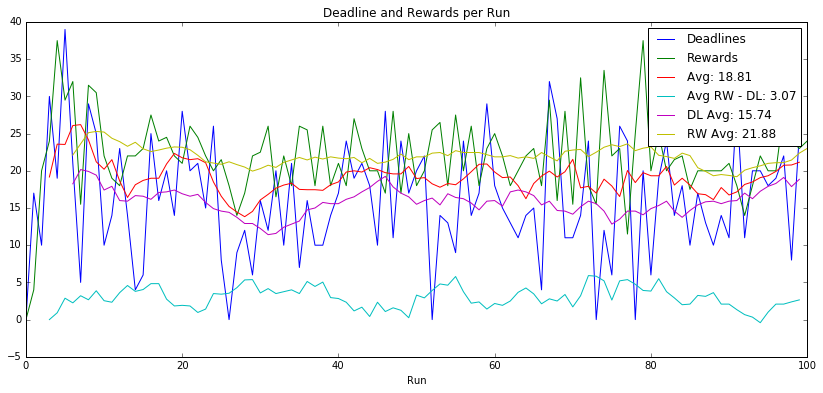


Q Learning Agent done


In [41]:
if __name__ == '__main__':
    print  "running...."
    QLearnFeatures,QLdeadlines,QLrewards=run(agentType=LearningAgent,trials=100, deadline=True,gui=console, delay=.1)
    #statsFromRun(QLearnFeatures,QLdeadlines,QLrewards)
    scorePerRun(QLdeadlines,QLrewards)
    print "\nQ Learning Agent done"

## Conclusion
We can see that the fully implemented agent has learned a set of rules governing road travel, including stop light behavior, and how to follow the route planner. Our agent quickly approaches this optimal policy state, with the caveat that it retains the ability(via epsilon settings) to learn changes. Since we have concentrated on 100 run trials,we will not see all possible states, and so can't reach a fully optimized policy. The possibility exists to save the policy and continue to learn, eventually having an entry for each possible state, and minimizing the mistakes. Until then, our agent is able to perform in a very acceptable manner for this environment.

#EOF